<a href="https://colab.research.google.com/github/Bryan-Az/Adv-Keras-NNs/blob/main/Part1/Vision-Model/Vision_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Keras Model
In this notebook, I will use computer vision object detection techniques using the Keras machine learning library to classify fashion product image data from the Fashion-MNIST dataset. In this section, I will be building a custom computer vision model.

## Imports

In [ ]:
# loads the libraries used in this notebook
! pip install tensorflow_text
import tensorflow_text
import tensorflow as tf
from tensorflow import feature_column
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [ ]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras

In [ ]:
os.environ["KERAS_BACKEND"] = "torch"  # I will be using torch as it is a dependency in our environment.yml
import keras
import keras_cv
import tensorflow_datasets as tfds

In [ ]:
! pip install datasets
import datasets

In [ ]:
import math

## The Data

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
num_classes=10

In [ ]:
fashion_mnist = datasets.load_dataset('fashion_mnist')

In [ ]:
train_fashion_ds = pd.DataFrame(fashion_mnist['train'])
test_fashion_ds = pd.DataFrame(fashion_mnist['test'])
train_fashion_ds.head()

,image,label
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,9
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,3
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0


In [ ]:
def convert_to_ds(feature):
    labels = []
    images = []
    def prepare_label_data(image, label, num_labels):
        images.append(np.array(image))
        labels.append(tf.one_hot(label, num_labels))
    feature.apply(lambda x: prepare_label_data(x['image'], x['label'], 10), axis=1)
    X_ds = tf.data.Dataset.from_tensor_slices(images)
    y_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip(X_ds, y_ds)

In [ ]:
train_fashion_xy = convert_to_ds(train_fashion_ds)
test_fashion_xy = convert_to_ds(test_fashion_ds)

In [ ]:
resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

In [ ]:
def package_inputs(image, label):
    # Duplicate the channel to create a 3-channel image
    rgb_image = tf.image.grayscale_to_rgb(tf.expand_dims(image, axis=-1))
    image = tf.cast(rgb_image, tf.float32)
    return {"images": resizing(image), "labels": label}

In [ ]:
train_ds = train_fashion_xy.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = test_fashion_xy.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_ds = train_ds.ragged_batch(BATCH_SIZE)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE)

In [ ]:
batch_train_sample = next(iter(train_ds.take(1)))
image_batch = batch_train_sample["images"]
label_batch = batch_train_sample["labels"]

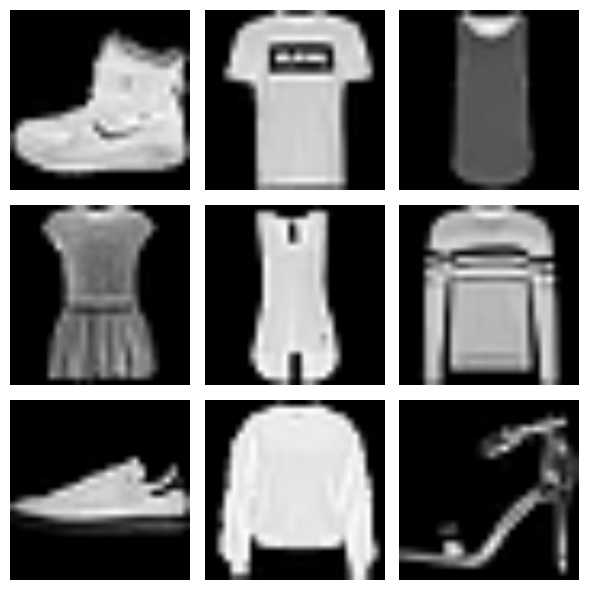

In [ ]:
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [ ]:
random_flip = keras_cv.layers.RandomFlip()
augmenters = [random_flip]


In [ ]:
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)
# apply only onto 30% to provide base + augmented data for training
train_ds = train_ds.skip(int(len(train_ds) * 0.7)).map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.skip(int(len(eval_ds) * 0.7)).map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
batch_train_sample = next(iter(train_ds.take(1)))
image_batch = batch_train_sample["images"]
label_batch = batch_train_sample["labels"]

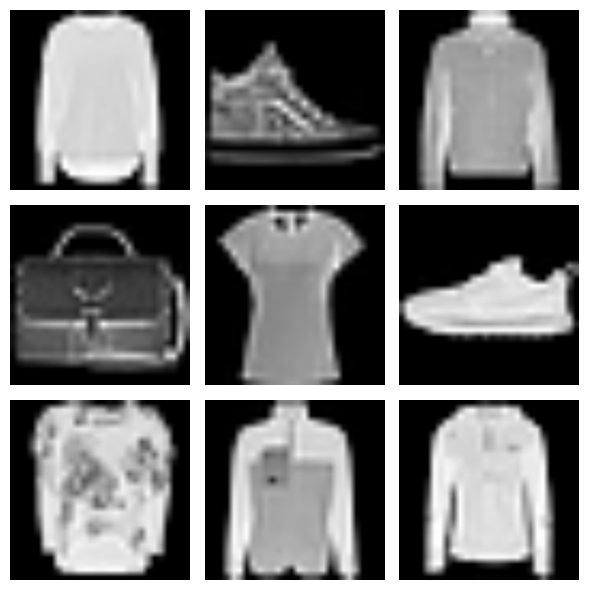

In [ ]:
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [ ]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]


train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

# The Model

In [ ]:
from keras.optimizers import schedules
from keras import optimizers, losses, metrics, ops
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )

        return ops.where(step > self.total_steps, 0.0, lr)

In [ ]:
total_images = 9000
total_steps = (total_images // BATCH_SIZE) * 1 # 1 is # Epochs
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)
optimizer = optimizers.SGD(
    weight_decay=5e-4,
    learning_rate=schedule,
    momentum=0.9,
)

In [ ]:
backbone = keras_cv.models.EfficientNetV2B0Backbone()
model = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

In [ ]:
loss = losses.CategoricalCrossentropy(label_smoothing=0.1)

In [ ]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[
        metrics.CategoricalAccuracy(name="accuracy"),
        metrics.TopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
    ],
)

In [ ]:
model.fit(
    train_ds,
    epochs=5,
    validation_data=eval_ds,
    verbose=1,
)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 247s 231ms/step - accuracy: 0.1882 - loss: 4.7488 - top-5-accuracy: 0.6450 - val_accuracy: 0.4930 - val_loss: 2.2071 - val_top-5-accuracy: 0.9402
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 115s 180ms/step - accuracy: 0.3600 - loss: 2.6853 - top-5-accuracy: 0.8809 - val_accuracy: 0.4893 - val_loss: 2.0438 - val_top-5-accuracy: 0.9365
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 140s 181ms/step - accuracy: 0.3605 - loss: 2.8310 - top-5-accuracy: 0.8849 - val_accuracy: 0.4823 - val_loss: 2.1332 - val_top-5-accuracy: 0.9392
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 148s 192ms/step - accuracy: 0.3585 - loss: 2.7821 - top-5-accuracy: 0.8792 - val_accuracy: 0.4856 - val_loss: 2.0677 - val_top-5-accuracy: 0.9395
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 141s 191ms/step - accuracy: 0.3563 - loss: 2.6573 - top-5-accuracy: 0.8864 - val_accuracy: 0.4796 - val_loss: 2.0551 - val_top-5-accuracy: 0.9398


## Conclusion

Using a preset model architecture backbone for computer vision tasks (efficient net - no pre-training/weights used), I was able to train a model that has minimal accuracy for detecting black and white images of articles of clothing, and classifying them across 10 different labels.

This may simply be a case of having too little training data, or having a pre-processing pipeline that needs to be refined a bit further. This experience taught me the complexity of training a custom keras model!

For example, many augmenters (such as hue) will have a tough time applying onto grey-scale images as they are not in the correct shape for augmentation - as it expects a 3-dimensional image.

It is also a good idea to provide the augmented data in addition or only as a subset of the main data.